In [1]:
from dolfinx import fem, mesh, plot, geometry
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import TrialFunction, Measure, TestFunction, dx, ds, grad, inner, lhs, rhs, div
from matplotlib import pyplot as plt, cm
import numpy as np
import pyvista

In [2]:
nx, ny = 50, 50
x1, y1 = 0.0, 0.0
x2, y2 = 0.1, 0.1
freq = 10000
omega = freq * 2 * np.pi
pressure = (-1.0, 0.0)
separator = 0.5

fluids = ((1000, 1500, 0.000894),
          (890, 1360, 2.022))

In [3]:
def omega_0(x):
    return x[1] <= y1 + (y2 - y1) * separator

def omega_1(x):
    return x[1] >= y1 + (y2 - y1) * separator

In [4]:
def get_boundaries():
    return ((1, lambda x: np.isclose(x[0], x1)),
            (2, lambda x: np.isclose(x[0], x2)),
            (3, lambda x: np.isclose(x[1], y1)),
            (4, lambda x: np.isclose(x[1], y2)))

In [5]:
def pyvista_plot(domain, values, title, show_edges=False):
    pyvista.start_xvfb()
    plotter = pyvista.Plotter(window_size=[800, 800])
    grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(domain, domain.topology.dim))
    grid.cell_data[title] = values
    grid.set_active_scalars(title)
    plotter.add_mesh(grid, show_edges=show_edges)
    plotter.view_xy()
    plotter.show()

In [6]:
def get_values(fun, x):
    domain = fun.function_space.mesh
    bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells = []
    points_on_proc = []
    
    cell_candidates = geometry.compute_collisions(bb_tree, x)
    
    colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, x)
    for i, point in enumerate(x):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])

    points_on_proc = np.array(points_on_proc, dtype=np.float64)

    return fun.eval(points_on_proc, cells)

In [7]:
def matplotlib_plot(fun, projection, titles, cmap=cm.viridis, levels=100):
    x = np.linspace(x1, x2, nx)
    y = np.linspace(y1, y2, ny)

    xx, yy = np.meshgrid(x, y)
    lin_shape = xx.shape[0] * xx.shape[1]

    compute_points = np.hstack((xx.ravel(), yy.ravel(), np.zeros(lin_shape))).reshape((3, lin_shape)).T
    values = [np.real(get_values(fun, compute_points)),
              np.imag(get_values(fun, compute_points))]

    if fun.function_space.num_sub_spaces == 0:
        zz = [vals[:, 0].reshape(xx.shape) for vals in values]
    else:
        zz = [np.linalg.norm(vals, axis=1).reshape(xx.shape) for vals in values]

    fig = plt.figure(constrained_layout=True, figsize=(14, 6))
    layout = ['1', '2']
    
    if projection == '3d':
        axd = fig.subplot_mosaic([layout], empty_sentinel='', subplot_kw={'projection': '3d'})
    else:
        axd = fig.subplot_mosaic([layout], empty_sentinel='')
    
    for i, ax_id in enumerate(layout):
        if projection == '3d':
            surf = axd[ax_id].plot_surface(xx, yy, zz[i], cmap=cmap)
            fig.colorbar(surf, ax=axd[ax_id], shrink=0.75)
        elif projection == '2d':
            surf = axd[ax_id].contourf(xx, yy, zz[i], levels, cmap=cmap)
            fig.colorbar(surf, ax=axd[ax_id])

        axd[ax_id].set_title(titles[i], fontsize=16)
        axd[ax_id].set_xlabel('x', fontsize=16)
        axd[ax_id].set_ylabel('y', fontsize=16)
        
    plt.show()


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



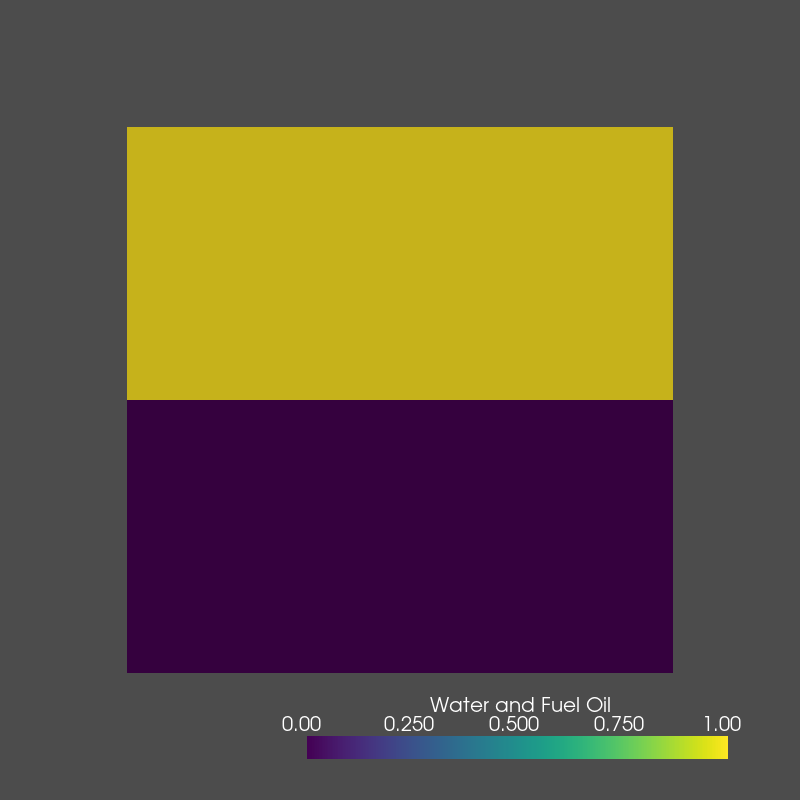

Iteration 1


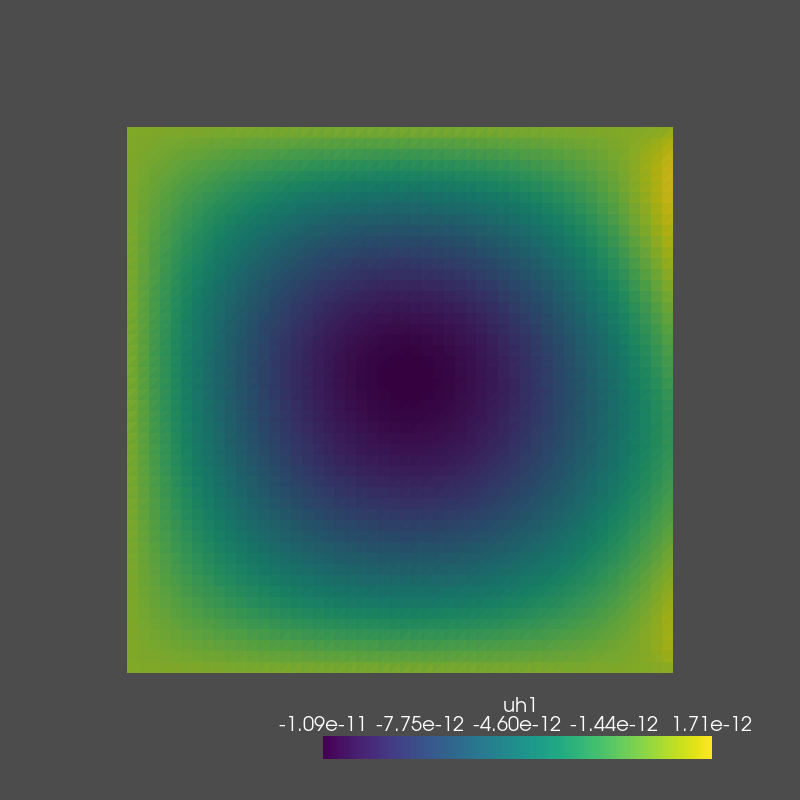

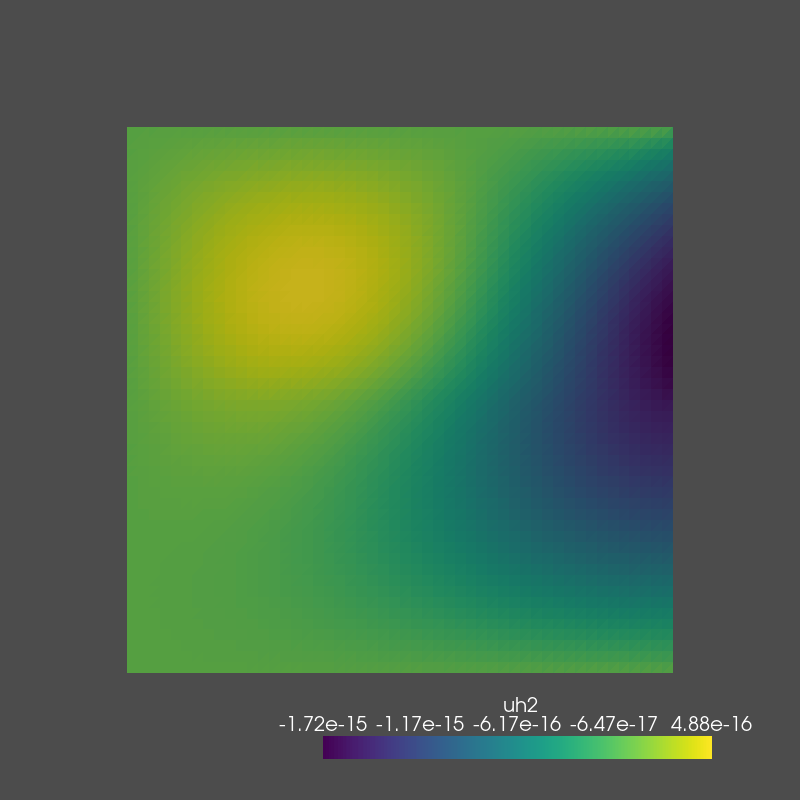

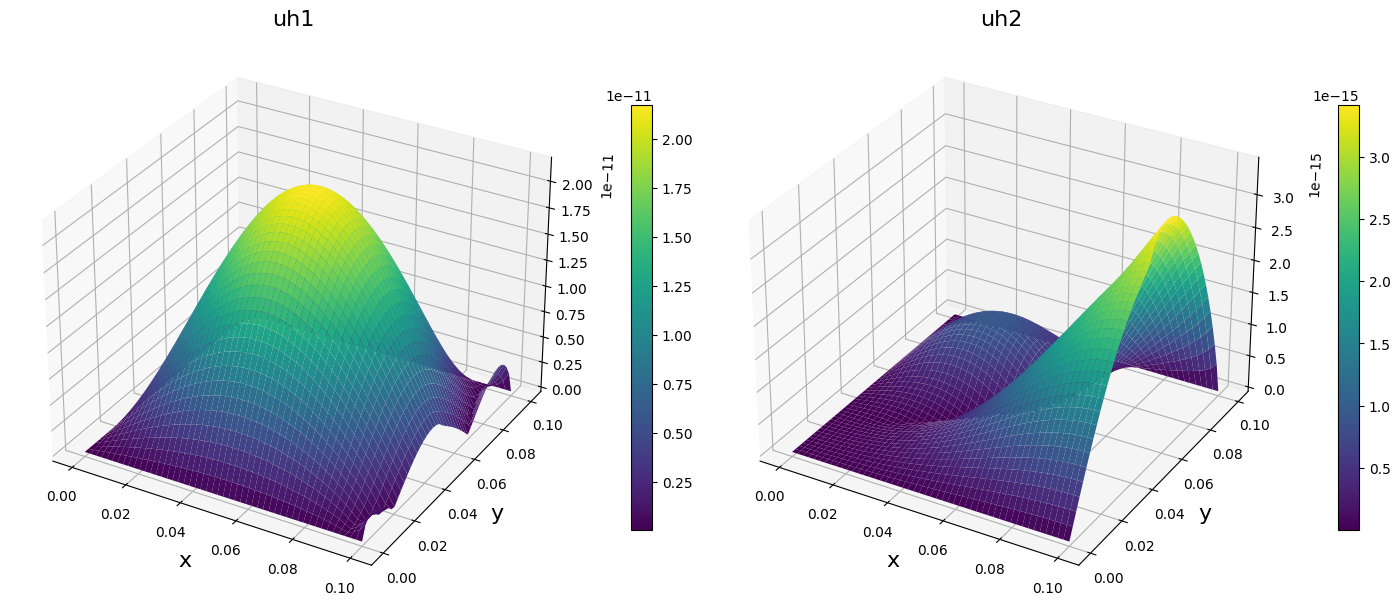

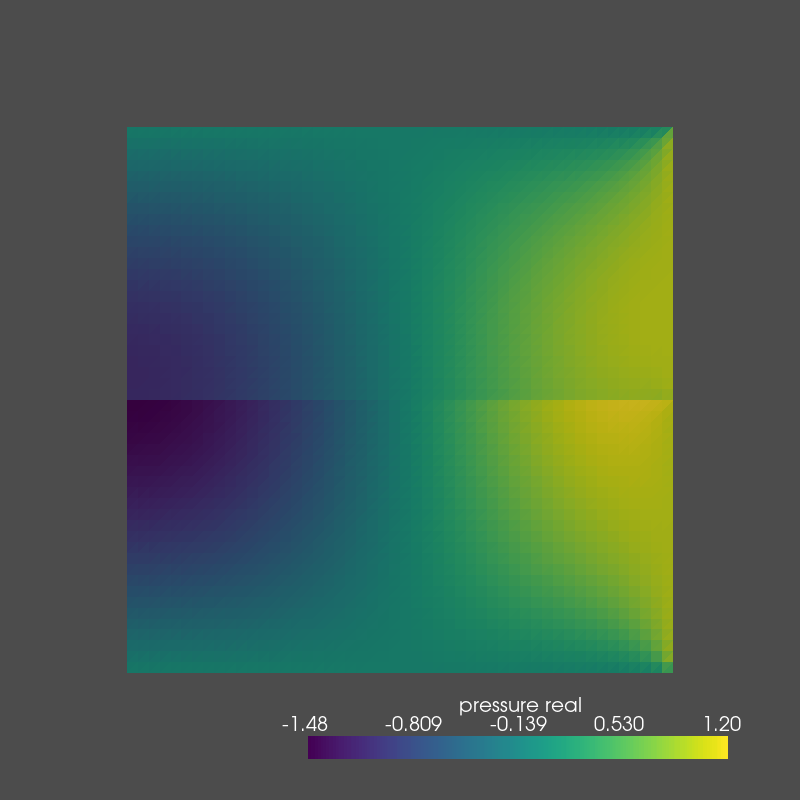

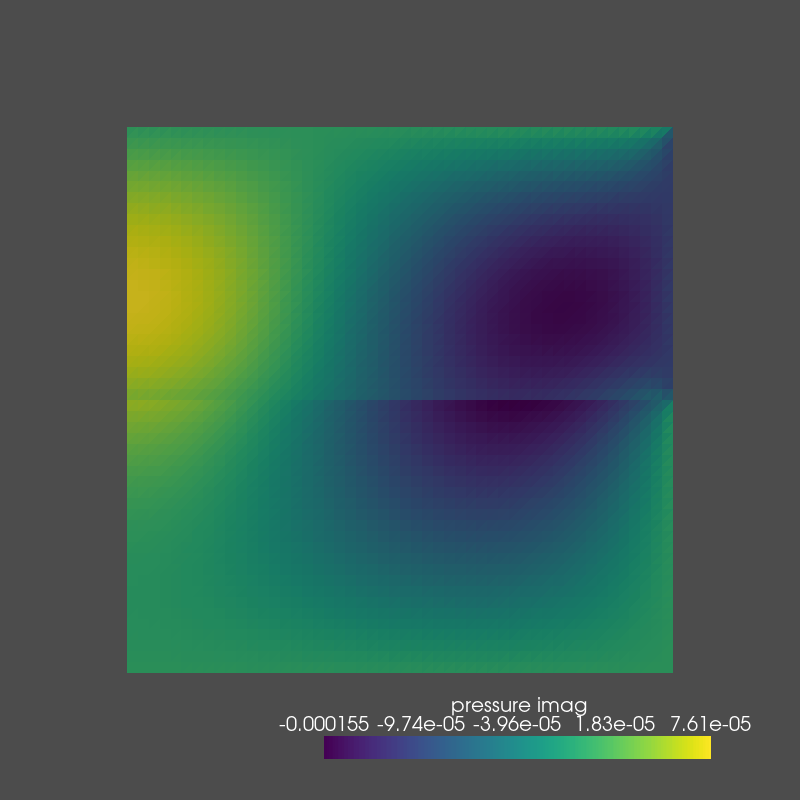

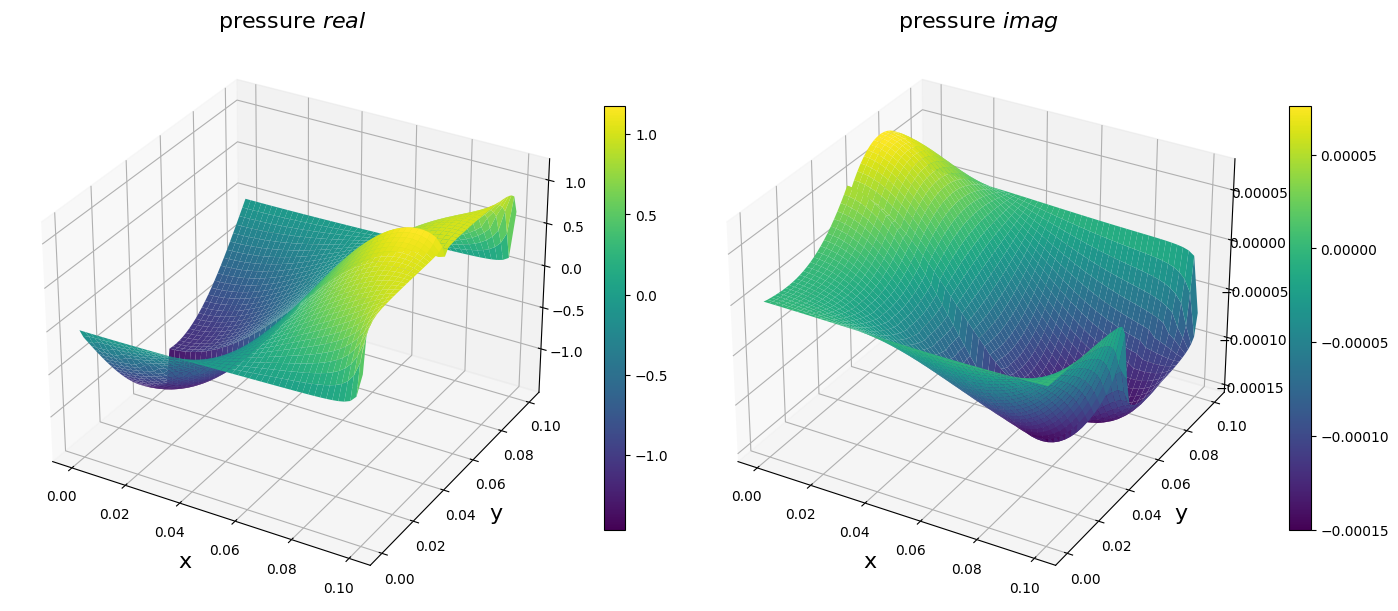

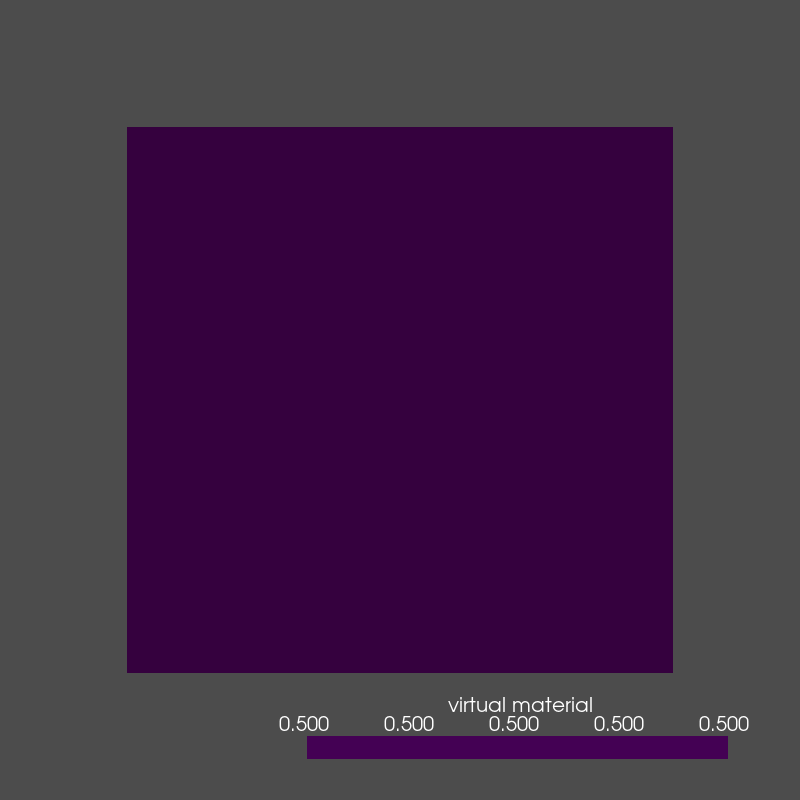

Iteration 16


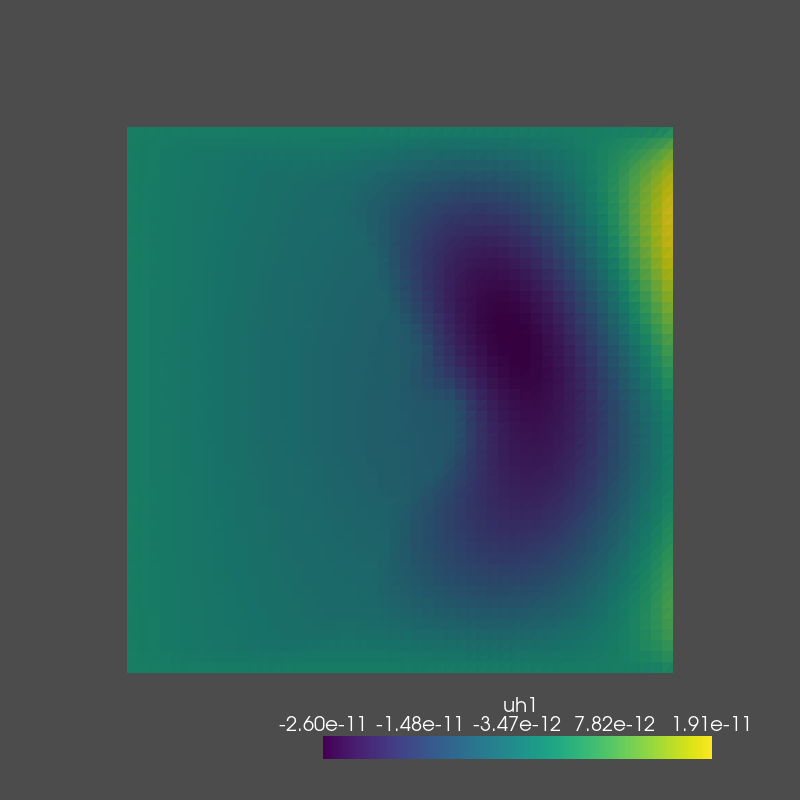

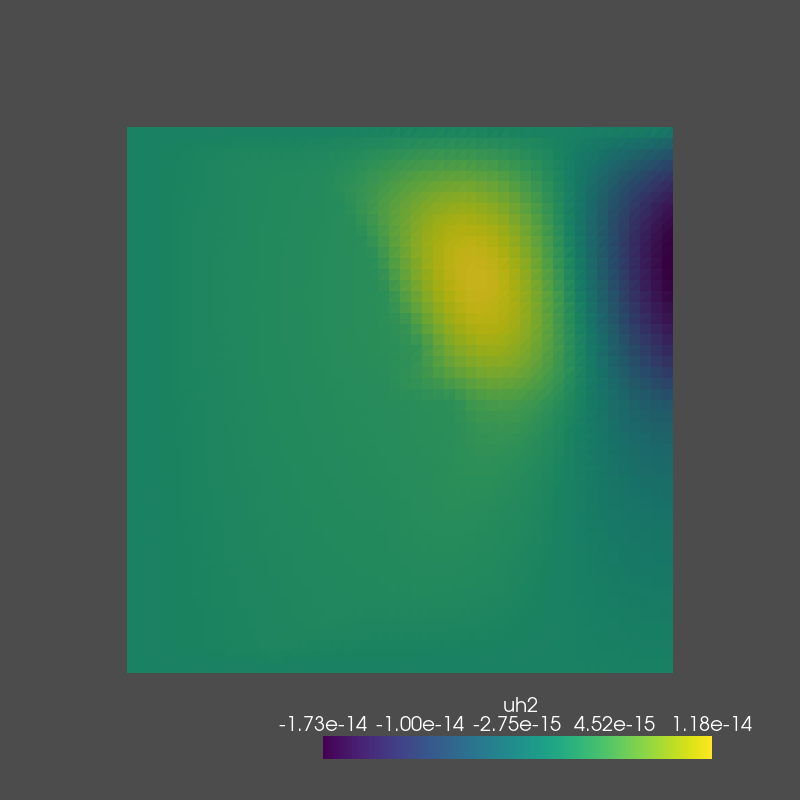

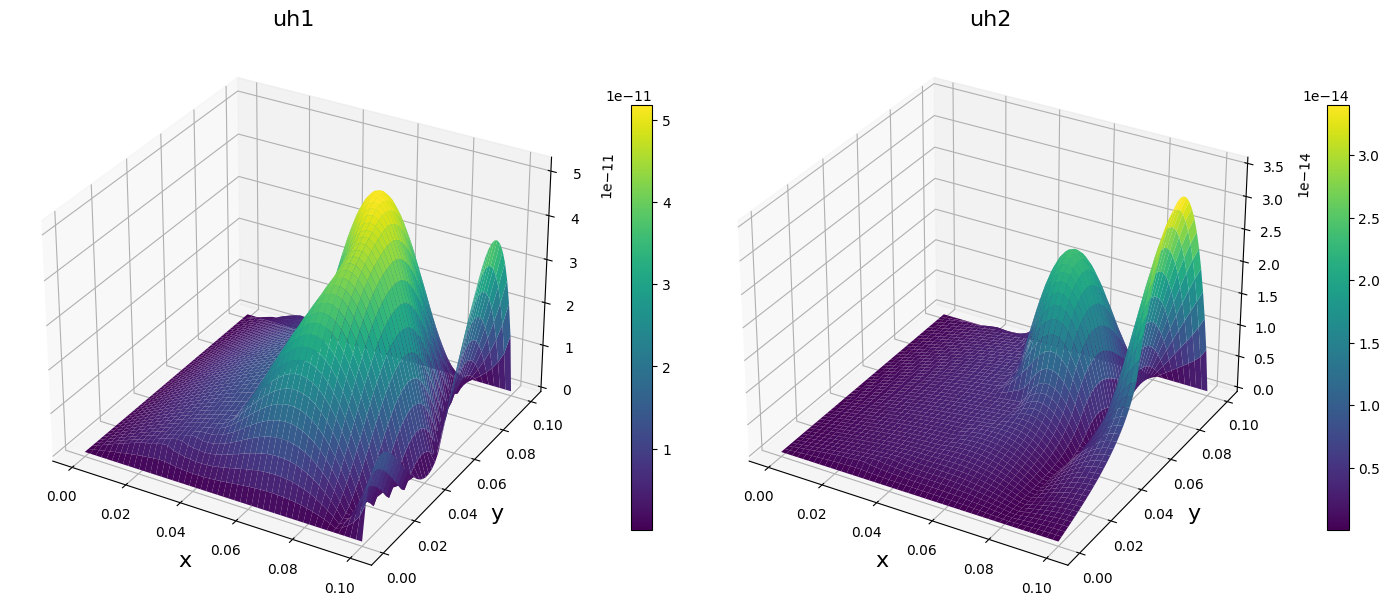

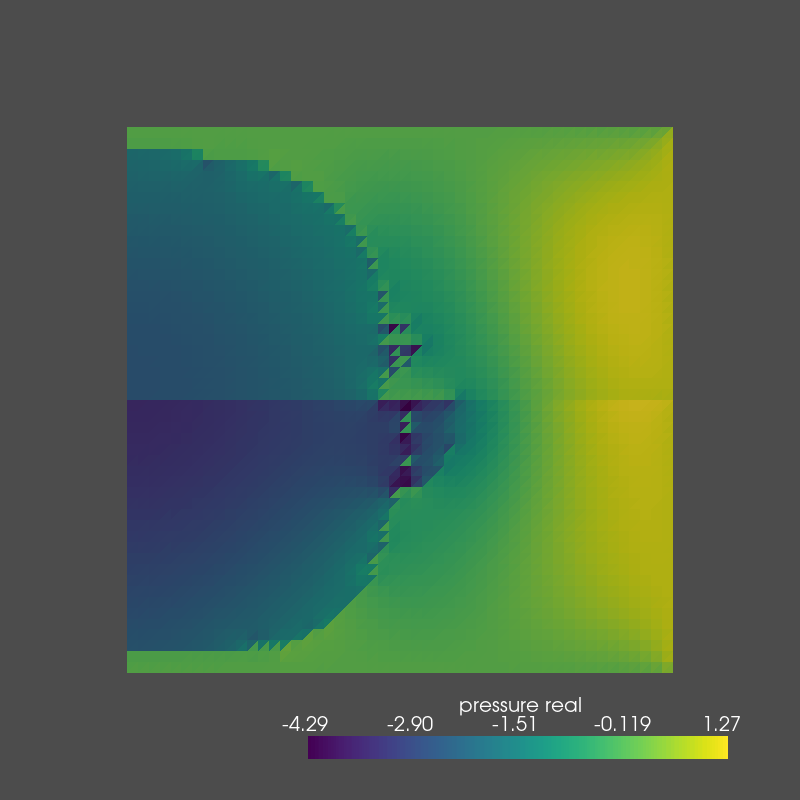

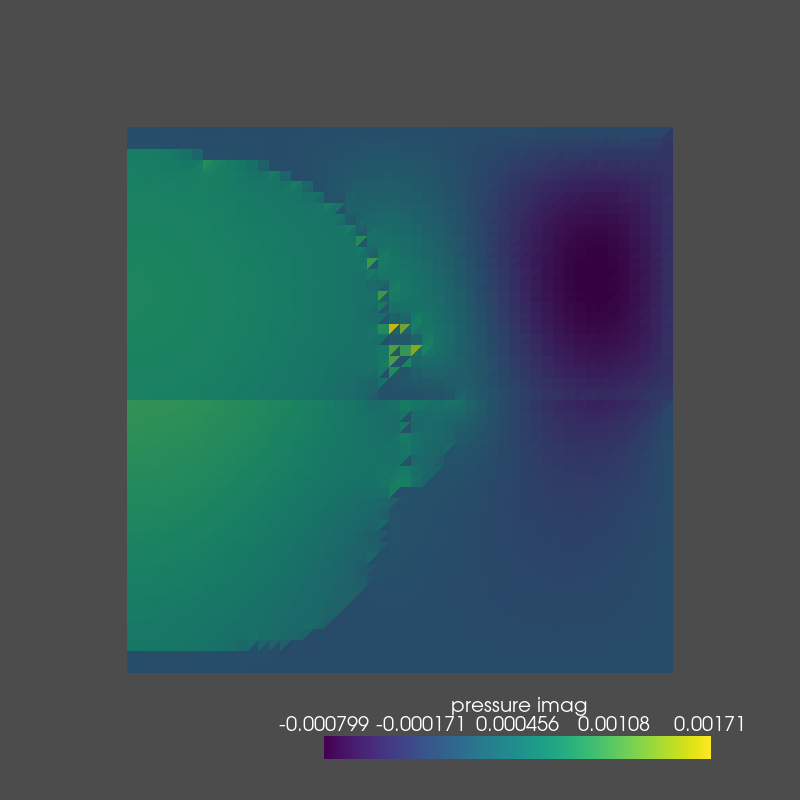

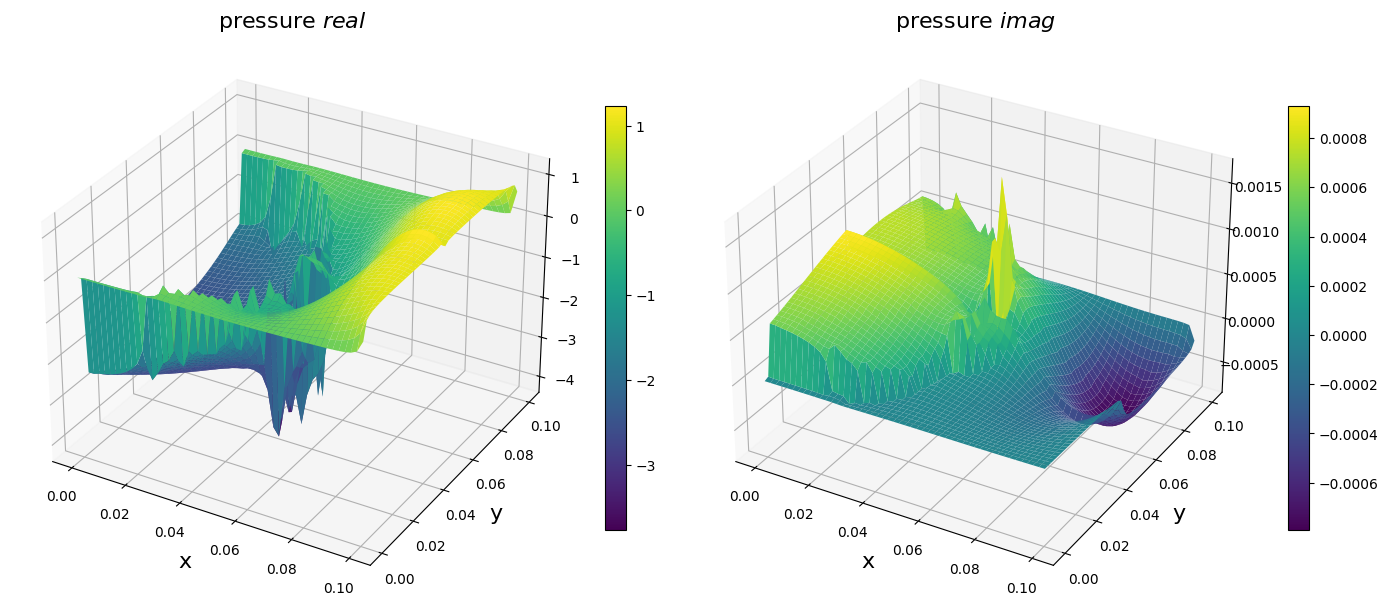

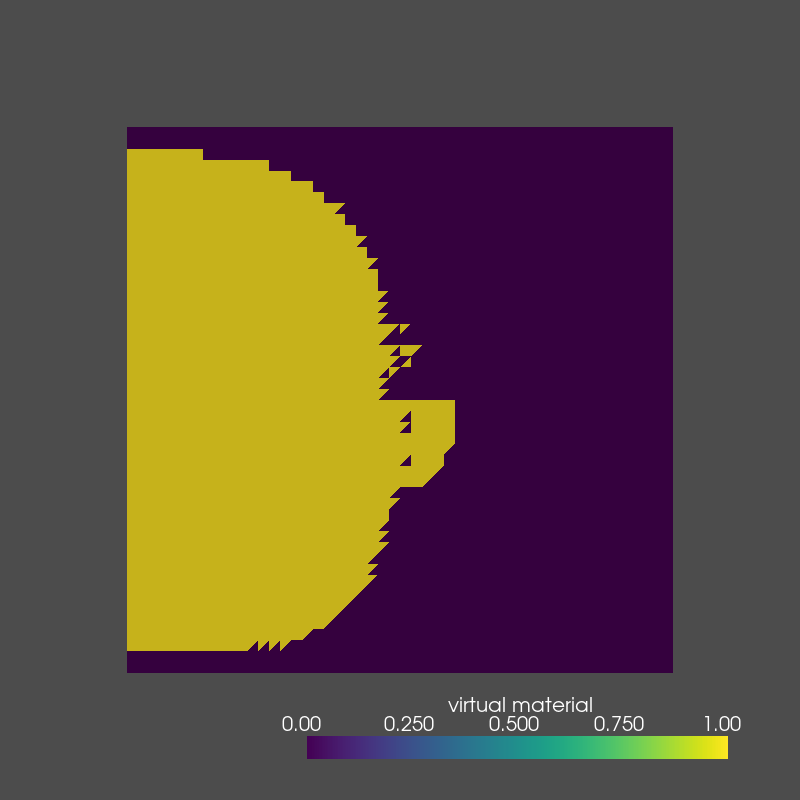

In [8]:
domain = mesh.create_rectangle(MPI.COMM_WORLD, [(x1, y1), (x2, y2)], [nx, ny])
V = fem.VectorFunctionSpace(domain, ('CG', 2))
Q = fem.FunctionSpace(domain, ('DG', 0))

u = TrialFunction(V)
v = TestFunction(V)

ro = fem.Function(Q)
c = fem.Function(Q)
eta = fem.Function(Q)
vm = fem.Function(Q)

cells_0 = mesh.locate_entities(domain, domain.topology.dim, omega_0)
cells_1 = mesh.locate_entities(domain, domain.topology.dim, omega_1)
cells = [cells_0, cells_1]

pyvista.start_xvfb()
num_cells_local = domain.topology.index_map(domain.topology.dim).size_local
marker = np.zeros(num_cells_local, dtype=np.int32)
for i, cell in enumerate(cells):
    cells[i] = cells[i][cell < num_cells_local]
marker[cell] = i
topology, cell_types, x = plot.create_vtk_mesh(domain, domain.topology.dim, np.arange(num_cells_local, dtype=np.int32))

plotter = pyvista.Plotter(window_size=[800, 800])
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
grid.cell_data['Water and Fuel Oil'] = marker
grid.set_active_scalars('Water and Fuel Oil')
plotter.add_mesh(grid, show_edges=False)
plotter.view_xy()
plotter.show()

for i, cell in enumerate(cells):
    density, speed, viscosity = fluids[i]
    ro.x.array[cell] = np.full_like(cell, density, dtype=ScalarType)
    c.x.array[cell] = np.full_like(cell, speed, dtype=ScalarType)
    eta.x.array[cell] = np.full_like(cell, viscosity, dtype=ScalarType)
    vm.x.array[cell] = np.full_like(cell, 0.5, dtype=ScalarType)
    
facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in get_boundaries():
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

ds = Measure('ds', domain=domain, subdomain_data=facet_tag)

step = 0.1
count = 1
vm_has_only_zeros_or_ones = False
while not vm_has_only_zeros_or_ones:
    if count > 1:
        pmin = np.min(p.x.array.real)
        pmax = np.max(p.x.array.real)
        pmid = (pmin + pmax) / 2
        for i, el in enumerate(p.x.array.real):
            prev = vm.x.array.real[i]
            if el < pmid and not np.isclose(prev, 0.0):
                vm.x.array.real[i] = min(1.0, prev + step)
                diff = vm.x.array.real[i] - prev
                ro.x.array[i] += ro.x.array[i] * diff
                c.x.array[i] += c.x.array[i] * diff
                eta.x.array[i] += eta.x.array[i] * diff
            elif el > pmid and not np.isclose(prev, 1.0):
                vm.x.array.real[i] = max(0.0, prev - step)
                diff = prev - vm.x.array.real[i]
                ro.x.array[i] -= ro.x.array[i] * diff
                c.x.array[i] -= c.x.array[i] * diff
                eta.x.array[i] -= eta.x.array[i] * diff
    
    aa = ro * c ** 2 * inner(grad(u), grad(v)) * dx
    mm = ro * inner(u, v) * dx
    cc = 4/3 * eta * inner(grad(u), grad(v)) * dx

    u_N = fem.Constant(domain, ScalarType(pressure))
    F = aa - omega ** 2 * mm + omega * 1.0j * cc + inner(u_N, v) * ds(2)

    bcs = []
    for marker in (1, 3, 4):
        u_D = fem.Function(V)
        u_D.interpolate(lambda x: (x[0] * 0.0, x[1] * 0.0))
        facets = facet_tag.find(marker)            
        dofs = fem.locate_dofs_topological(V, fdim, facets)
        bcs.append(fem.dirichletbc(u_D, dofs))
    
    Left = lhs(F)
    Right = rhs(F)
    problem = fem.petsc.LinearProblem(Left, Right, bcs, petsc_options={'ksp_type': 'preonly', 'pc_type': 'lu'})
    uh = problem.solve()
    
    p = fem.Function(Q)
    p.interpolate(fem.Expression(ro * c ** 2 * div(uh), Q.element.interpolation_points()))
            
    vm_has_only_zeros_or_ones = np.all([np.isclose(el, 0.0) or np.isclose(el, 1.0) for el in vm.x.array.real])
    
    if count == 1 or vm_has_only_zeros_or_ones:
        print(f'Iteration {count}')
        uh1, uh2 = uh.split()
        mod_uh = fem.Function(Q)
        mod_uh.interpolate(fem.Expression((uh1 + uh2) / 2, Q.element.interpolation_points()))
        pyvista_plot(domain, mod_uh.x.array.real, 'uh1')
        pyvista_plot(domain, mod_uh.x.array.imag, 'uh2')
        matplotlib_plot(uh, '3d', ['uh1', 'uh2'])
        pyvista_plot(domain, p.x.array.real, 'pressure real')
        pyvista_plot(domain, p.x.array.imag, 'pressure imag')
        matplotlib_plot(p, '3d', [r'pressure $real$', r'pressure $imag$'])
        pyvista_plot(domain, vm.x.array.real, 'virtual material')
    count += 1